목표 : 오픈 데이터로 존재하는 얼굴 이미지 데이터를 수집해 감정을 인식하는 AI 모델 개발 

목적 : Tips 사업 관련 학습자의 집중도를 파악하기 위해 이와 유관한 감정을 예측하려고 함

1. 데이터셋 수집


*   얼굴 이미지 관련 open data로 Affectnet의 얼굴 이미지 데이터 활용 예정
*   여러 Face dataset들이 존재하고 각각 감정을 분류하는 범주들의 개수 및 기준이 다르기 때문에 다음으로 소개될 Azure Face API와 범주개수 및 분류기준이 동일한 Affectnet이 가장 적절한 데이터로 판단하여 선택
*   다운로드 URL : https://www.kaggle.com/datasets/mouadriali/affectnetsample?sort=most-comments
*   원본 데이터는 백만 여개의 이미지에 해당하며 직접 다운로드 및 요청에 많은 시간이 소요되기에 이를 대신하여 Kaggle의 Affectnet sample 데이터로 분석 진행
*   원본 URL : http://mohammadmahoor.com/affectnet/ 
*   trainset 3만 7천여개 이미지와 validation set 4천여개의 이미지로 구성 
*   총 8가지 감정(anger, contempt, disgust, fear, happiness, neutral, sadness, surprise)으로 분류가 가능

2. API 소개


*   Microsoft의 Azure Cognitive service에서 제공하는 Face API를 사용하여 모델링 진행
*   URL : https://azure.microsoft.com/ko-kr/ 
*   이미지에서 사람의 얼굴을 감지, 인식 및 분석하는 AI 알고리즘을 제공
*   Microsoft 회원가입 및 Azure 무료 구독을 신청하여 Azure Portal를 접속
*   Azure에서는 다양한 AI 기술 및 머신러닝 기법 등을 제공하며 이 중 Face API를 활용해 key 호출



3. Modeling 

*   API key 호출
*   얼굴 감지 및 감정 인식 모델 구축
*   Kaggle 데이터 업로드
*   1개 이미지에 대한 감정 인식 결과 도출
*   전체 이미지에 대한 감정 인식 결과 도출
*   인식한 결과 저장(dataframe, jpg 파일)

4. 모델 평가 및 해석


1.   다중 분류 모델 평가지표를 활용하여 결과 도출
2.   평가결과 해석



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install --upgrade azure-cognitiveservices-vision-face

In [ ]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
import pandas as pd
from urllib.parse import urlparse
from io import BytesIO
# To install this module, run:
# python -m pip install Pillow
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, QualityForRecognition, FaceAttributeType

In [ ]:
# This key will serve all examples in this document.
KEY = ""

# This endpoint will be used in all examples in this quickstart.
ENDPOINT = "https://emotion-recognition.cognitiveservices.azure.com/"

In [ ]:
# face api client 기능 불러오기  
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [ ]:
features = [FaceAttributeType.age, FaceAttributeType.gender, FaceAttributeType.emotion, FaceAttributeType.head_pose]

In [ ]:
emotion = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

In [ ]:
# 이미지의 감정을 분석하는 함수 구성 - 입력값 : 이미지 파일 경로값(외부 url은 불가), 데이터프레임으로 구축할 비어있는 리스트 입력 
def get_emotion(image_url, list_name) : 
  image_path = os.path.join(image_url)
  image_stream = open(image_path, "rb")
  # face 객체 감지
  detected_faces = face_client.face.detect_with_stream(image=image_stream, return_face_attributes=features)
  # if len(detected_faces) > 0:
  # print(len(detected_faces), 'faces detected.')

  # Prepare image for drawing
  fig = plt.figure(figsize=(8, 6))
  plt.axis('off')
  image = Image.open(image_stream)
  draw = ImageDraw.Draw(image)
  color = 'lightgreen'

  # Draw and annotate each face
  for face in detected_faces:
      emotion_list = []
      # 이미지 이름 저장
      emotion_list.append(os.path.basename(image_url))
      # 탐지한 얼굴 id 저장
      # print('\nFace ID: {}'.format(face.face_id))
      emotion_list.append(face.face_id)
      # Label 저장
      '''
      for em in emotion :
        if em in image_url :
          emotion_list.append(em)
          break
      '''
      detected_attributes = face.face_attributes.as_dict()

      if 'head_pose' in detected_attributes :
        for pose in detected_attributes['head_pose'] :
          emotion_list.append(detected_attributes['head_pose'][pose])

      # 예측한 prediction 값 출력을 위한 객체 생성
      max_value = None
      emotion_str = None  
      if 'emotion' in detected_attributes:
          # print(' - Emotions:')
          # emotion 개수(8개)만큼 반복하여 값 출력 및 저장
          for emotion_name in detected_attributes['emotion']:
              # print('   - {}: {}'.format(emotion_name, detected_attributes['emotion'][emotion_name]))
              emotion_list.append(detected_attributes['emotion'][emotion_name])
              # prediction(emotion 최댓값) 찾기
              if (max_value is None or detected_attributes['emotion'][emotion_name] > max_value) :
                max_value = detected_attributes['emotion'][emotion_name]
                emotion_str = emotion_name
              elif (max_value == detected_attributes['emotion'][emotion_name]) :
                emotion_str = emotion_str + ', ' + emotion_name

      # Draw and annotate face
      r = face.face_rectangle
      bounding_box = ((r.left, r.top), (r.left + r.width, r.top + r.height))
      draw = ImageDraw.Draw(image)
      draw.rectangle(bounding_box, outline=color, width=5)
      # annotation = 'Face ID: {}'.format(face.face_id)
      annotation = emotion_str + ' : ' + str(max_value)
      plt.annotate(annotation,(r.left, r.top), backgroundcolor=color)
      emotion_list.append(emotion_str)
      list_name.append(emotion_list)

  # Save annotated image / directory setting
  plt.imshow(image)
  # outputfile = '/content/drive/MyDrive/Colab Notebooks/sentiment analysis/detected_faces.jpg'
  # fig.savefig(outputfile)
  # print('\nResults saved in', outputfile)

In [ ]:
def show_face_attributes(image_url):
    # Open an image
    image_path = os.path.join(image_url)
    image_stream = open(image_path, "rb")
    detected_faces = face_client.face.detect_with_stream(image=image_stream, return_face_attributes=features)
    img = Image.open(image_path)

    # Create a figure to display the results
    fig = plt.figure(figsize=(8, 6))

    if detected_faces:
        # If there are faces, how many?
        num_faces = len(detected_faces)
        prediction = ' (' + str(num_faces) + ' faces detected)'
        # Draw a rectangle around each detected face
        for face in detected_faces:
            r = face.face_rectangle
            bounding_box = ((r.left, r.top), (r.left + r.width, r.top + r.height))
            draw = ImageDraw.Draw(img)
            draw.rectangle(bounding_box, outline='magenta', width=5)

            # Annotate with face attributes (only age and emotion are used in this sample)
            detected_attributes = face.face_attributes.as_dict()
            age = 'age unknown' if 'age' not in detected_attributes.keys() else int(detected_attributes['age'])
            # annotations = 'Person aged approximately {}'.format(age)
            annotations = '8 type of emotions'
            txt_lines = 1
            if 'emotion' in detected_attributes.keys():
                for emotion_name in detected_attributes['emotion']:
                    txt_lines += 1
                    annotations += '\n - {}: {}'.format(emotion_name, detected_attributes['emotion'][emotion_name])
            # plt.annotate(annotations,((r.left + r.width)/10, (r.top + r.height + (txt_lines * 12))/10), backgroundcolor='white')
            plt.annotate(annotations,(r.width, (r.top + r.height + (txt_lines * 12))/5), backgroundcolor='white')
            print(detected_attributes['head_pose'])
        # Plot the image
        #a = fig.add_subplot(1,1,1)
        # fig.suptitle(prediction)

    plt.axis('off')
    plt.imshow(img)

    # outputfile = '/content/drive/MyDrive/Colab Notebooks/sentiment analysis/sentiment_analysis.jpg'
    # fig.savefig(outputfile)

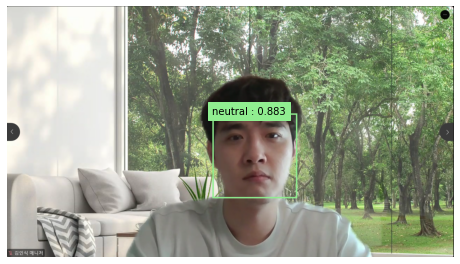

In [ ]:
url1 = '/content/drive/MyDrive/Colab Notebooks/sentiment analysis/concentration/focused/focused_1.PNG'
temp = []
get_emotion(url1, temp)

{'roll': -0.3, 'yaw': 4.5, 'pitch': 2.8}


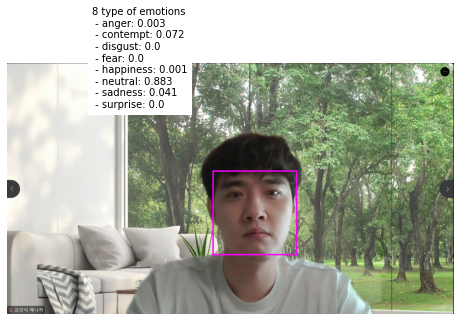

In [ ]:
show_face_attributes(url1)

In [ ]:
pd.DataFrame(temp, columns=['image_name', 'face_id', 'roll', 'yaw', 'pitch', 'anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise', 'predictions'])

,image_name,face_id,roll,yaw,pitch,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,predictions
0,image0000030.jpg,dfac4ead-b23e-47c7-87fc-c765d2016058,-2.9,23.6,-10.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,happiness


[업로드 준비사항] <br>


*   Kaggle에 본인계정으로 접속하여 Account 설정 찾기
*   Account 설정에서 본인의 api token이 기록된 kaggle.json 파일을 다운로드 받아 directory에 저장
*   해당 파일이 directory 내에 존재해야 정상적으로 kaggle DB에 접근하여 다운로드가 가능하기에 directory 초기화 이슈 고려하여 유의



In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download mouadriali/affectnetsample

 99% 1.74G/1.75G [00:14<00:00, 107MB/s]
100% 1.75G/1.75G [00:14<00:00, 125MB/s]


In [ ]:
! unzip affectnetsample.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_class/class008/image0040203.jpg  
  inflating: train_class/class008/image0040207.jpg  
  inflating: train_class/class008/image0040213.jpg  
  inflating: train_class/class008/image0040216.jpg  
  inflating: train_class/class008/image0040223.jpg  
  inflating: train_class/class008/image0040225.jpg  
  inflating: train_class/class008/image0040230.jpg  
  inflating: train_class/class008/image0040232.jpg  
  inflating: train_class/class008/image0040236.jpg  
  inflating: train_class/class008/image0040237.jpg  
  inflating: train_class/class008/image0040240.jpg  
  inflating: train_class/class008/image0040247.jpg  
  inflating: train_class/class008/image0040253.jpg  
  inflating: train_class/class008/image0040255.jpg  
  inflating: train_class/class008/image0040257.jpg  
  inflating: train_class/class008/image0040258.jpg  
  inflating: train_class/class008/image0040259.jpg  
  inflating: train_class/class008/image0040261.jpg  
  inflatin

In [ ]:
os.rename('/content/train_class/class001', '/content/train_class/neutral')
os.rename('/content/train_class/class002', '/content/train_class/happiness')
os.rename('/content/train_class/class003', '/content/train_class/sadness')
os.rename('/content/train_class/class004', '/content/train_class/surprise')
os.rename('/content/train_class/class005', '/content/train_class/fear')
os.rename('/content/train_class/class006', '/content/train_class/disgust')
os.rename('/content/train_class/class007', '/content/train_class/anger')
os.rename('/content/train_class/class008', '/content/train_class/contempt')

In [ ]:
os.listdir('train_class')

['disgust',
 'surprise',
 'sadness',
 'neutral',
 'fear',
 'contempt',
 'anger',
 'happiness']

In [ ]:
example_list = []
input_path = '/content/train_class/happiness/image0000030.jpg'
get_emotion(input_path, example_list)

In [ ]:
show_face_attributes(input_path)

In [ ]:
result_data = pd.DataFrame(example_list, columns=['image_name', 'face_id', 'roll', 'yaw', 'pitch', 'anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise', 'predictions'])
result_data

In [ ]:
'''
dataset_directory = '/content/train_class'
sentiment_list = []
'''

In [ ]:
dataset_directory = '/content/drive/MyDrive/Colab Notebooks/sentiment analysis/concentration/focused'
focused_list = []

for file in os.listdir(dataset_directory) : 
  image_url = f'{dataset_directory}/{file}'
  get_emotion(image_url, focused_list)

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

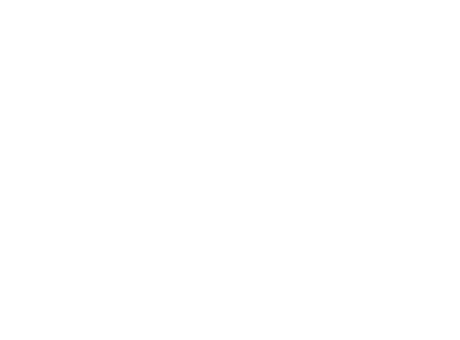

ValueError: ignored

<Figure size 576x432 with 1 Axes>

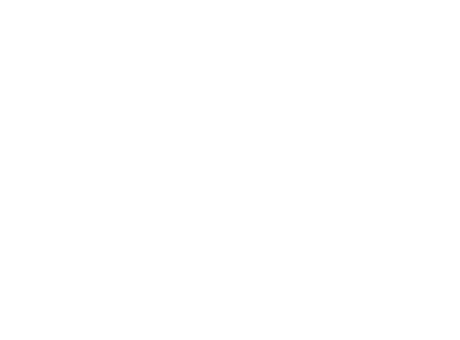

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

ValueError: ignored

<Figure size 576x432 with 1 Axes>

In [ ]:
dataset_directory1 = '/content/drive/MyDrive/Colab Notebooks/sentiment analysis/concentration/unfocused'
unfocused_list = []

for file in os.listdir(dataset_directory1) : 
  image_url = f'{dataset_directory1}/{file}'
  get_emotion(image_url, unfocused_list)

[문제점] <br> 

* Azure Face API Free Tier의 경우 분당 20개의 transaction이 가능 / 월단위로 30,000개의 transaction 가능 <br>

* 현재 이미지 데이터의 경우 3만 7천여개에 해당하기 때문에 free tier는 분석이 불가능하며 유료버전 사용 또는 데이터셋을 줄여 분석이 가능 <br> 

* val_class 데이터가 4,000개로 충분한 분석이 가능할 것으로 보이지만 1분당 20개만 처리할 수 있기에 총 200분이상의 시간소요가 예상 <br>

* Free Tier 상에서 20개를 먼저 처리하고 기다리는 중에 runtime 연결이 끊기며 초기화되는 이슈가 존재하여 결과 도출이 불완전 <br>

* Azure Face API 가격정책 URL : https://azure.microsoft.com/en-us/pricing/details/cognitive-services/face-api/ 

* 유료버전 사용 시 한번 분석하는데 38달러가 청구될 것으로 예상(트랜잭션 1000건당 1달러) 

In [ ]:
'''
for folder in os.listdir(dataset_directory) :
  file_path = f'{dataset_directory}/{folder}'
  for file in os.listdir(file_path) : 
    image_url = f'{dataset_directory}/{folder}/{file}'
    get_emotion(image_url, sentiment_list)
'''

In [ ]:
fn_result = pd.DataFrame(focused_list, columns=['image_name', 'face_id', 'roll', 'yaw', 'pitch', 'anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise', 'predictions'])
fn_result

,image_name,face_id,roll,yaw,pitch,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,predictions
0,focused_1.PNG,dea377d6-4ae2-4ab2-8ba5-fa0455e7eaec,-0.3,4.5,2.8,0.003,0.072,0.0,0.0,0.001,0.883,0.041,0.000,neutral
1,focused_2.PNG,1b0efe37-8261-4176-819b-ab923bb49ae5,-5.2,-8.3,0.6,0.000,0.000,0.0,0.0,0.000,0.996,0.004,0.000,neutral
2,focused_3.PNG,27835c21-580b-4323-bfa3-791da40337cd,4.0,11.8,-30.8,0.000,0.002,0.0,0.0,0.000,0.995,0.001,0.002,neutral
3,focused_4.PNG,f0571811-1b36-4acc-a8cf-97026a7776f2,6.8,10.2,-30.5,0.000,0.020,0.0,0.0,0.000,0.976,0.003,0.000,neutral
4,focused_5.PNG,f249a131-6ebb-4683-a2c6-2868629e07dd,1.0,7.5,2.1,0.000,0.000,0.0,0.0,0.000,0.999,0.001,0.000,neutral
5,focused_6.PNG,b7adebc6-eb41-4a06-8ae6-ec0d09b00980,-5.4,1.7,-2.0,0.002,0.000,0.0,0.0,0.000,0.996,0.001,0.000,neutral
6,focused_7.PNG,d4a53ebb-9195-4c79-b9c1-477a1416209b,-0.1,1.7,3.3,0.000,0.000,0.0,0.0,0.000,1.000,0.000,0.000,neutral


In [ ]:
fn_result['yaw'].abs()

In [ ]:
print(fn_result['yaw'].abs().mean())
print(fn_result['pitch'].abs().mean())
print("Yaw 25% : ", fn_result['yaw'].abs().quantile(0.25))
print("Yaw 50% : ", fn_result['yaw'].abs().quantile(0.50))
print("Yaw 75% : ", fn_result['yaw'].abs().quantile(0.75))
print("Yaw 25% : ", fn_result['pitch'].abs().quantile(0.25))
print("Yaw 50% : ", fn_result['pitch'].abs().quantile(0.50))
print("Yaw 75% : ", fn_result['pitch'].abs().quantile(0.75))

6.528571428571429
10.299999999999999
Yaw 25% :  3.1
Yaw 50% :  7.5
Yaw 75% :  9.25
Yaw 25% :  2.05
Yaw 50% :  2.8
Yaw 75% :  16.9


In [ ]:
un_result = pd.DataFrame(unfocused_list, columns=['image_name', 'face_id', 'roll', 'yaw', 'pitch', 'anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise', 'predictions'])
un_result

,image_name,face_id,roll,yaw,pitch,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,predictions
0,unfocused_1.PNG,82cee406-896a-482f-ba13-848c0ae775bf,-2.9,-12.0,-0.4,0.002,0.012,0.001,0.001,0.001,0.882,0.098,0.002,neutral
1,unfocused_3.PNG,24a0e5f6-4e35-4fab-9e0e-79936aa29fb4,1.4,-4.9,-26.3,0.022,0.006,0.002,0.000,0.000,0.953,0.018,0.000,neutral
2,unfocused_5.PNG,f3e92ab4-3cf8-4956-bfa1-4d9fa8f2c44e,1.9,2.1,5.2,0.005,0.113,0.001,0.000,0.002,0.847,0.032,0.000,neutral
3,unfocused_6.PNG,92206ec8-6df0-4fef-911d-63e7a30e2e1c,1.2,8.6,-8.5,0.000,0.044,0.000,0.000,0.761,0.195,0.000,0.000,happiness
4,unfocused_7.PNG,41e6a0f3-b2bd-40a2-9b90-0d55e9829b44,2.7,3.7,-17.1,0.000,0.000,0.000,0.000,0.000,0.986,0.014,0.000,neutral
5,unfocused_8.PNG,23bd7f30-17be-44a0-a0c1-c2224475c52e,4.6,5.2,-22.9,0.000,0.001,0.000,0.000,0.047,0.948,0.004,0.000,neutral
6,unfocused_9.PNG,298fcda4-bf86-486b-bb0b-d5a088bb0ba7,7.0,10.9,-2.4,0.000,0.000,0.000,0.000,0.000,0.999,0.001,0.000,neutral


In [ ]:
print(un_result['yaw'].abs().mean())
print(un_result['pitch'].abs().mean())
print("Yaw 25% : ", un_result['yaw'].abs().quantile(0.25))
print("Yaw 50% : ", un_result['yaw'].abs().quantile(0.50))
print("Yaw 75% : ", un_result['yaw'].abs().quantile(0.75))
print("Yaw 25% : ", un_result['pitch'].abs().quantile(0.25))
print("Yaw 50% : ", un_result['pitch'].abs().quantile(0.50))
print("Yaw 75% : ", un_result['pitch'].abs().quantile(0.75))

6.771428571428571
11.828571428571431
Yaw 25% :  4.300000000000001
Yaw 50% :  5.2
Yaw 75% :  9.75
Yaw 25% :  3.8
Yaw 50% :  8.5
Yaw 75% :  20.0


In [ ]:
print((fn_result['yaw'].abs().mean()+un_result['yaw'].abs().mean())/2)
print((fn_result['pitch'].abs().mean()+un_result['pitch'].abs().mean())/2)

In [ ]:
result = pd.concat([fn_result, un_result], ignore_index=True)
result

,image_name,face_id,roll,yaw,pitch,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,predictions
0,focused_1.PNG,dea377d6-4ae2-4ab2-8ba5-fa0455e7eaec,-0.3,4.5,2.8,0.003,0.072,0.000,0.000,0.001,0.883,0.041,0.000,neutral
1,focused_2.PNG,1b0efe37-8261-4176-819b-ab923bb49ae5,-5.2,-8.3,0.6,0.000,0.000,0.000,0.000,0.000,0.996,0.004,0.000,neutral
2,focused_3.PNG,27835c21-580b-4323-bfa3-791da40337cd,4.0,11.8,-30.8,0.000,0.002,0.000,0.000,0.000,0.995,0.001,0.002,neutral
3,focused_4.PNG,f0571811-1b36-4acc-a8cf-97026a7776f2,6.8,10.2,-30.5,0.000,0.020,0.000,0.000,0.000,0.976,0.003,0.000,neutral
4,focused_5.PNG,f249a131-6ebb-4683-a2c6-2868629e07dd,1.0,7.5,2.1,0.000,0.000,0.000,0.000,0.000,0.999,0.001,0.000,neutral
5,focused_6.PNG,b7adebc6-eb41-4a06-8ae6-ec0d09b00980,-5.4,1.7,-2.0,0.002,0.000,0.000,0.000,0.000,0.996,0.001,0.000,neutral
6,focused_7.PNG,d4a53ebb-9195-4c79-b9c1-477a1416209b,-0.1,1.7,3.3,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,neutral
7,unfocused_1.PNG,82cee406-896a-482f-ba13-848c0ae775bf,-2.9,-12.0,-0.4,0.002,0.012,0.001,0.001,0.001,0.882,0.098,0.002,neutral
8,unfocused_3.PNG,24a0e5f6-4e35-4fab-9e0e-79936aa29fb4,1.4,-4.9,-26.3,0.022,0.006,0.002,0.000,0.000,0.953,0.018,0.000,neutral
9,unfocused_5.PNG,f3e92ab4-3cf8-4956-bfa1-4d9fa8f2c44e,1.9,2.1,5.2,0.005,0.113,0.001,0.000,0.002,0.847,0.032,0.000,neutral


In [ ]:
label = []
for a in range(len(result)):
  if 'unfocused' in result['image_name'][a] :
    label.append(1)
  else :
    label.append(0)
result['label'] = label
result

,image_name,face_id,roll,yaw,pitch,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,predictions,label
0,focused_1.PNG,dea377d6-4ae2-4ab2-8ba5-fa0455e7eaec,-0.3,4.5,2.8,0.003,0.072,0.000,0.000,0.001,0.883,0.041,0.000,neutral,0
1,focused_2.PNG,1b0efe37-8261-4176-819b-ab923bb49ae5,-5.2,-8.3,0.6,0.000,0.000,0.000,0.000,0.000,0.996,0.004,0.000,neutral,0
2,focused_3.PNG,27835c21-580b-4323-bfa3-791da40337cd,4.0,11.8,-30.8,0.000,0.002,0.000,0.000,0.000,0.995,0.001,0.002,neutral,0
3,focused_4.PNG,f0571811-1b36-4acc-a8cf-97026a7776f2,6.8,10.2,-30.5,0.000,0.020,0.000,0.000,0.000,0.976,0.003,0.000,neutral,0
4,focused_5.PNG,f249a131-6ebb-4683-a2c6-2868629e07dd,1.0,7.5,2.1,0.000,0.000,0.000,0.000,0.000,0.999,0.001,0.000,neutral,0
5,focused_6.PNG,b7adebc6-eb41-4a06-8ae6-ec0d09b00980,-5.4,1.7,-2.0,0.002,0.000,0.000,0.000,0.000,0.996,0.001,0.000,neutral,0
6,focused_7.PNG,d4a53ebb-9195-4c79-b9c1-477a1416209b,-0.1,1.7,3.3,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,neutral,0
7,unfocused_1.PNG,82cee406-896a-482f-ba13-848c0ae775bf,-2.9,-12.0,-0.4,0.002,0.012,0.001,0.001,0.001,0.882,0.098,0.002,neutral,1
8,unfocused_3.PNG,24a0e5f6-4e35-4fab-9e0e-79936aa29fb4,1.4,-4.9,-26.3,0.022,0.006,0.002,0.000,0.000,0.953,0.018,0.000,neutral,1
9,unfocused_5.PNG,f3e92ab4-3cf8-4956-bfa1-4d9fa8f2c44e,1.9,2.1,5.2,0.005,0.113,0.001,0.000,0.002,0.847,0.032,0.000,neutral,1


In [ ]:
result['predict'] = 0

for a in range(len(result)) :
  if result['predictions'][a] != 'neutral':
    result['predict'][a] = 1
  else :
    if (result['yaw'][a]>6.77 or result['yaw'][a]<-6.77 or result['pitch'][a]>11.83 or result['pitch'][a]<-11.83) :
      result['predict'][a] = 1
    else : 
      result['predict'][a] = 0      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
result

,image_name,face_id,roll,yaw,pitch,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,predictions,label,predict
0,focused_1.PNG,dea377d6-4ae2-4ab2-8ba5-fa0455e7eaec,-0.3,4.5,2.8,0.003,0.072,0.000,0.000,0.001,0.883,0.041,0.000,neutral,0,0
1,focused_2.PNG,1b0efe37-8261-4176-819b-ab923bb49ae5,-5.2,-8.3,0.6,0.000,0.000,0.000,0.000,0.000,0.996,0.004,0.000,neutral,0,1
2,focused_3.PNG,27835c21-580b-4323-bfa3-791da40337cd,4.0,11.8,-30.8,0.000,0.002,0.000,0.000,0.000,0.995,0.001,0.002,neutral,0,1
3,focused_4.PNG,f0571811-1b36-4acc-a8cf-97026a7776f2,6.8,10.2,-30.5,0.000,0.020,0.000,0.000,0.000,0.976,0.003,0.000,neutral,0,1
4,focused_5.PNG,f249a131-6ebb-4683-a2c6-2868629e07dd,1.0,7.5,2.1,0.000,0.000,0.000,0.000,0.000,0.999,0.001,0.000,neutral,0,1
5,focused_6.PNG,b7adebc6-eb41-4a06-8ae6-ec0d09b00980,-5.4,1.7,-2.0,0.002,0.000,0.000,0.000,0.000,0.996,0.001,0.000,neutral,0,0
6,focused_7.PNG,d4a53ebb-9195-4c79-b9c1-477a1416209b,-0.1,1.7,3.3,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,neutral,0,0
7,unfocused_1.PNG,82cee406-896a-482f-ba13-848c0ae775bf,-2.9,-12.0,-0.4,0.002,0.012,0.001,0.001,0.001,0.882,0.098,0.002,neutral,1,1
8,unfocused_3.PNG,24a0e5f6-4e35-4fab-9e0e-79936aa29fb4,1.4,-4.9,-26.3,0.022,0.006,0.002,0.000,0.000,0.953,0.018,0.000,neutral,1,1
9,unfocused_5.PNG,f3e92ab4-3cf8-4956-bfa1-4d9fa8f2c44e,1.9,2.1,5.2,0.005,0.113,0.001,0.000,0.002,0.847,0.032,0.000,neutral,1,0


처음 수집한 20개 데이터로 평가를 시도하였지만 데이터가 충분히 확보되지 않아 불완전한 것으로 판단

In [ ]:
y_true = result['label'].tolist()
y_pred = result['predict'].tolist()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, plot_roc_curve, roc_curve, accuracy_score

In [ ]:
print(confusion_matrix(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[3 4]
 [1 6]]
0.6428571428571429
0.6
0.8571428571428571
0.6428571428571429
              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.60      0.86      0.71         7

    accuracy                           0.64        14
   macro avg       0.68      0.64      0.63        14
weighted avg       0.67      0.64      0.63        14



In [ ]:
# 다중 분류 모델의 confusion matrix를 그리는 함수 생성
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import numpy as np
import itertools

Confusion matrix, without normalization
[[3 4]
 [1 6]]


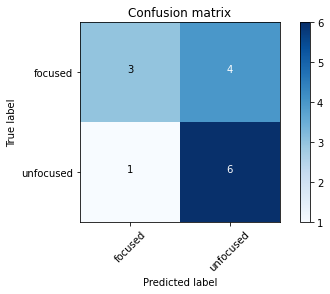

In [ ]:
classes_list = ['focused', 'unfocused']
confusion_mtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mtx, classes=classes_list)

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

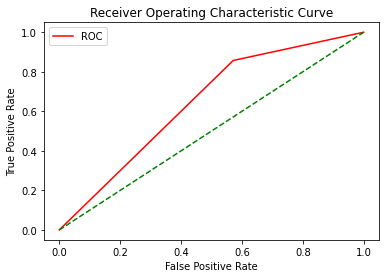

In [ ]:
fper, tper, thresholds = roc_curve(y_true, y_pred)
plot_roc_curve(fper, tper)

In [ ]:
pro_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment analysis/pro_data.csv")

In [ ]:
yy_true = pro_data['label'].tolist()
yy_pred = pro_data['predict'].tolist()

Confusion matrix, without normalization
[[5 2]
 [2 7]]


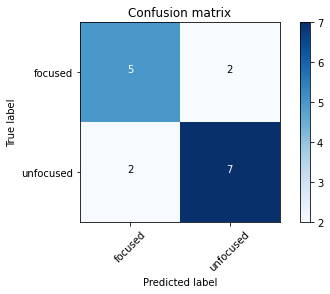

In [ ]:
confusion_mtxx = confusion_matrix(yy_true, yy_pred)
plot_confusion_matrix(confusion_mtxx, classes=classes_list)

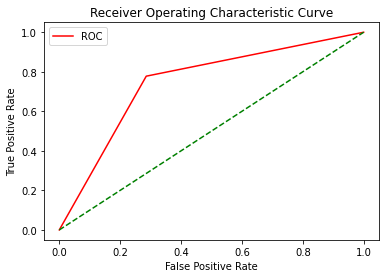

In [ ]:
fper, tper, thresholds = roc_curve(yy_true, yy_pred)
plot_roc_curve(fper, tper)

문제점 해결방향 

1.   무료버전을 계속해서 사용할 경우

     *   이미지 데이터 축소 필수(기존 3만 7천여개에서 4천개 또는 그 이하 수준으로)
     *   transaction 시간 설정으로 runtime이 끊겨 초기화되는 이슈를 해결
     *   분당 20개씩 처리하기에 이를 코드 내에서 인식시켜 분단위로 transaction 처리하는 코드 구성(리서치가 필요) 
     *   Azure Face API 이외 다른 API Tool 리서치(구글의 경우에도 제공되는 무료 크레딧으로 2천개만 분석 가능, 새로운 Tool 사용 시 더 많은 리서치 시간이 요구됨)


2.   유료버전을 사용할 경우

     *   결제를 위한 MS 공용계정 필요
     *   Azure 사용 시 개인의 결제 카드를 등록해야 회원가입 및 서비스 이용이 가능하기 때문에 개인 단위로 유료 결제 서비스를 이용하기 보다는 공용계정을 사용하는 것이 요금 정산 및 처리에 적절하다고 판단
     *   무분별한 비용 청구를 방지하기 위한 코드 재검토 필요
     *   유료버전 사용 시 초당 10개의 transaction 처리가 가능하며 백만 개 이하 단위 transaction 시 1000개당 1달러를 청구
     *   3만 7천여개의 이미지 데이터를 처리한다고 할 때, 매 분석 시 38 달러의 비용, 1시간 이상의 분석시간이 필요할 것으로 생각
     *   한번 분석 시마다 많은 비용이 청구되기에 원하는 결과값을 모두 도출해낼 수 있는지, 코드 상에 에러는 없는지, runtime 끊길 위험은 없는지 등을 검토하여 최대한 분석횟수를 줄여 비용을 감소시키는 것이 중요





대표님 미팅 이후 리서치할 요소


1.   정량적인 내용 추가 / 연구개발보고서에 필요한 내용이기에 리서치한 내용들을 추가적으로 작성하여 어느정도 분량을 구성하는 것이 중요
2.   유료버전 미사용 및 실제 알랩 내 집중도 사진 업데이트 / API 모델을 적용하는 것이고 실제 집중도 유무를 체크하는 이미지를 알랩 내에서 다량으로 수집하는 것이 적절
3.   집중도 유무 파악 metrics 0.75 이상 / 집중을 하는 표정은 8가지 감정 중 neutral에 가장 가깝기에 netural인지 / 아닌지를 판단하는 이진 분류 형식으로 labeling하여 예측값 도출

